In [1]:
#@title Materials for this exercise is taken from Colab google research group. Double click for more information 
#License information is below.
#Copyright 2020 Google LLC. 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Learning Objectives:

  * Use various methods (bin/buckets, feature cross) to represent features.
  

## The Dataset
  
This exercise uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

In [1]:
#@title Run TensorFlow
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
#@title Load the imports

# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

print("Imported the modules.")

Imported the modules.


## Load, scale, and shuffle the examples

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

The code cell then scales the `median_house_value` to a more human-friendly range and then shuffles the examples.

In [3]:
#@title Loading, scaling and randominzing 


# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

train_df.head(20)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
15828,-122.4,40.6,23.0,2248.0,489.0,1132.0,444.0,1.6,80.4
405,-117.0,33.8,10.0,6890.0,1702.0,3141.0,1451.0,1.7,95.9
6109,-118.2,34.1,33.0,2612.0,646.0,2496.0,606.0,3.1,156.0
7878,-118.4,34.1,32.0,8262.0,1156.0,2712.0,1125.0,10.6,500.0
3105,-117.8,33.8,15.0,3207.0,647.0,1414.0,595.0,4.0,165.6
...,...,...,...,...,...,...,...,...,...
6464,-118.3,34.1,38.0,2265.0,801.0,2899.0,792.0,2.6,157.5
13179,-121.9,37.2,23.0,2705.0,449.0,1180.0,442.0,6.1,316.5
14460,-122.1,37.5,41.0,3233.0,540.0,1251.0,506.0,6.6,500.0
5207,-118.1,33.8,41.0,1509.0,325.0,821.0,314.0,4.1,223.0


## Represent latitude and longitude as floating-point values

Previous Colabs trained on only a single feature or a single synthetic feature. By contrast, this exercise trains on two features. Furthermore, this Colab introduces **feature columns**, which provide a sophisticated way to represent features.  

You create feature columns as possible:

  * Call a [`tf.feature_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column) method to represent a single feature, single feature cross, or single synthetic feature in the desired way.  For example, to represent a certain feature as floating-point values, call [`tf.feature_column.numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column). To represent a certain feature as a series of buckets or bins, call [`tf.feature_column.bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column).
  * Assemble the created representations into a Python list. 

A neighborhood's location is typically the most important feature in determining a house's value. The California Housing dataset provides two features, `latitude` and `longitude` that identify each neighborhood's location. 

The following code cell calls [`tf.feature_column.numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) twice, first to represent `latitude` as floating-point value and a second time to represent `longitude` as floating-point values. 

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `fp_feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 


In [4]:
#@title Representation using floating-point values
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent latitude.
latitude = tf.feature_column.numeric_column("latitude")
feature_columns.append(latitude)

# Create a numerical feature column to represent longitude.
longitude = tf.feature_column.numeric_column("longitude")
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

When used, the layer processes the raw inputs, according to the transformations described by the feature columns, and packs the result into a numeric array.  (The model will train on this numeric array.) 

## Define functions that create and train a model, and a plotting function

The following code defines three functions:

  * `create_model`, which tells TensorFlow to build a linear regression model and to use the `feature_layer_as_fp` as the representation of the model's features.
  * `train_model`, which will ultimately train the model from training set examples.
  * `plot_the_loss_curve`, which generates a loss curve.

In [5]:
#@title Define functions to create and train a model, and a plotting function
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the mean absolute error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse   


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()  

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


C:\Users\Liam Glennie\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 5s 3ms/step - loss: 15449.2119 - root_mean_squared_error: 124.2949
Epoch 2/30
170/170 [==============================] - 1s 4ms/step - loss: 13634.8896 - root_mean_squared_error: 116.7685A: 0s - loss: 13898.8643 - root_mean_squared_erro
Epoch 3/30
170/170 [==============================] - 1s 4ms/step - loss: 13580.6992 - root_mean_squared_error: 116.5363
Epoch 4/30
170/170 [==============================] - 1s 4ms/step - loss: 13526.6777 - root_mean_squared_error: 116.3042
Epoch 5/30
170/170 [==============================] - 0s 2ms/step - loss: 13460.5635 - root_mean_squared_error: 116.0197A: 0s - loss: 13561.4238 - root_mean_squared_error: 116.
Epoch 6/30
170/170 [==============================] - 0s 2ms/step - loss: 13415.7119 - root_mean_squared_error: 115.8262
Epoch 7/30
170/170 [==============================] - 0s 3m

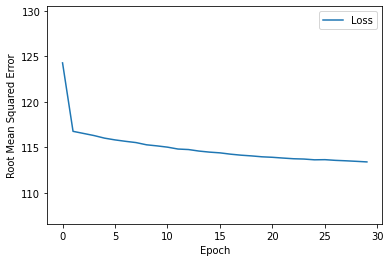


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 2ms/step - loss: 12292.0361 - root_mean_squared_error: 110.8695


[12292.0361328125, 110.86945343017578]

In [6]:

#@title Train the model with floating-point representations
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 1: Why aren't floating-point values a good way to represent latitude and longitude?



Using floating-point values to represent latitude and longitude we would be giving an unfair weight to different values. For example, latitudes and longitudes with higher value will have more weight and influence on the outcome calculated by the model. And latitudes and longitudes with lower values, won't have enough weight possibly meaning that the model would favour latitudes and longitudes with higher values.

## Task 2: Complete the code cell below by creating a bucket feature column for longitude

## Represent latitude and longitude in buckets

The following code cell represents latitude in buckets (bins). Each bin represents all the neighborhoods within a single degree. For example,
neighborhoods at latitude 35.4 and 35.8 are in the same bucket, but neighborhoods in latitude 35.4 and 36.2 are in different buckets. 

The model will learn a separate weight for each bucket. For example, the model will learn one weight for all the neighborhoods in the "35" bin", a different weight for neighborhoods in the "36" bin, and so on. This representation will create approximately 20 buckets:
 
  * 10 buckets for `latitude`. 
  * 10 buckets for `longitude`. 

In [7]:
#@title Data representation using buckets. **Double-click to add your code here to represent longitude in buckets for Task 2**
resolution_in_degrees = 1.0 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])), 
                                     resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
                                               latitude_boundaries)
feature_columns.append(latitude)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                     int(max(train_df['longitude'])), 
                                     resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                               longitude_boundaries)

feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
buckets_feature_layer = layers.DenseFeatures(feature_columns)

Epoch 1/35
Consider rewriting this model with the Functional API.


C:\Users\Liam Glennie\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 4ms/step - loss: 52070.1680 - root_mean_squared_error: 228.1889
Epoch 2/35
170/170 [==============================] - 1s 4ms/step - loss: 44676.6406 - root_mean_squared_error: 211.3685
Epoch 3/35
170/170 [==============================] - 1s 3ms/step - loss: 38085.4336 - root_mean_squared_error: 195.1549
Epoch 4/35
170/170 [==============================] - 0s 3ms/step - loss: 32299.2266 - root_mean_squared_error: 179.7198
Epoch 5/35
170/170 [==============================] - 1s 3ms/step - loss: 27259.0371 - root_mean_squared_error: 165.1031
Epoch 6/35
170/170 [==============================] - 1s 3ms/step - loss: 23021.1406 - root_mean_squared_error: 151.7272
Epoch 7/35
170/170 [==============================] - 0s 3ms/step - loss: 19482.7207 - root_mean_squared_error: 139.5805A: 0s - loss: 19986.7383 - root_mean_squared_error: 141
Epoch 8/35
170/170 [==============================] - 

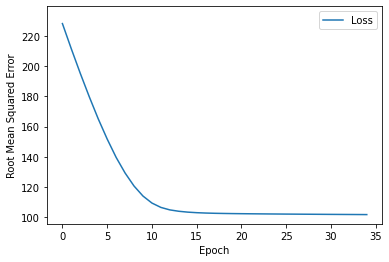


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 2ms/step - loss: 10199.9814 - root_mean_squared_error: 100.9950


[10199.9814453125, 100.99495697021484]

In [8]:
#@title Train the model with bucket representations
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the buckets_feature_layer.
my_model = create_model(learning_rate, buckets_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 3: Did buckets outperform floating-point representations? What is a better way to represent location?

Compare the model's `root_mean_squared_error` values for the two representations (floating-point vs. buckets)?  Which model produced lower losses? 

With the difference between RMSE of the two models being almost 10, we can say that the buckets version outperformed the floating-point representation. Therefore, using buckets is better because it is a fairer way of representing location, giving each bucket an appropriate weight. 


In [25]:
#@title Represent location as a feature cross

#The following code cell represents location as a feature cross. That is, the following code cell first creates buckets and then calls `tf.feature_column.crossed_column` to cross the buckets.
resolution_in_degrees = 0.5

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

Epoch 1/35
Consider rewriting this model with the Functional API.


C:\Users\Liam Glennie\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 6ms/step - loss: 53622.9141 - root_mean_squared_error: 231.5662
Epoch 2/35
170/170 [==============================] - 1s 4ms/step - loss: 48737.7344 - root_mean_squared_error: 220.7662
Epoch 3/35
170/170 [==============================] - 1s 4ms/step - loss: 44169.5352 - root_mean_squared_error: 210.1655
Epoch 4/35
170/170 [==============================] - 1s 4ms/step - loss: 39923.7344 - root_mean_squared_error: 199.8092A: 0s - loss: 40492.2148 - root_mean_squared_error: 201.
Epoch 5/35
170/170 [==============================] - 1s 4ms/step - loss: 35979.6016 - root_mean_squared_error: 189.6829A: 0s - loss: 36816.6484 - root_mean_squared_error: 191
Epoch 6/35
170/170 [==============================] - 1s 4ms/step - loss: 32347.9746 - root_mean_squared_error: 179.8554
Epoch 7/35
170/170 [==============================] - 1s 4ms/step - loss: 29037.1914 - root_mean_squared_error: 170.403

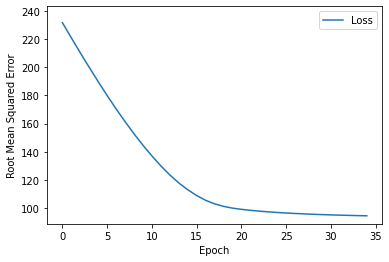


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 3ms/step - loss: 9008.8516 - root_mean_squared_error: 94.9150


[9008.8515625, 94.91497039794922]

In [26]:
#@title Test your model performance using feature cross.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 4: Did the feature cross outperform buckets?

Compare the model's `root_mean_squared_error` values for the two representations (buckets vs. feature cross)?  Which model produced
lower losses? 

If we compare the RMSE of the two models, we can observe that the model trained with feature cross outperformed the one trained with buckets. With the buckets method, we would feeding the model 2 one-hot feature vectors of size N. However, by performing feature cross on the latitude and longitude, we are giving the model 1 one-hot feature vector of size N*N. This allows the model to adjust the weights of each of the possible combinations better and achieve less error.

## Task 5: Adjust the resolution of the feature cross

Return to the code cell in the "Represent location as a feature cross" section. Notice that `resolution_in_degrees` is set to 1.0. Therefore, each cell represents an area of 1.0 degree of latitude by 1.0 degree of longitude, which corresponds to a cell of 110 km by 90 km.  This resolution defines a rather large neighborhood. 

Experiment with `resolution_in_degrees` to answer the following questions:

  1. What value of `resolution_in_degrees` produces the best results (lowest loss value)?
  2. Why does loss increase when the value of `resolution_in_degrees` drops below a certain value?


The value for resolution_in_degrees that seems to produce the best results is 0.5 reducing the area to 55km by 45km. If we were to reduce the value of resolution_in_degrees, we would be reducing the area to a size that is too small for the model to learn optimally. This could be because there are buckets that don't have enough representation for the model to learn it correctly.

## Task 6: Create the following feature cross 
* **[binned latitude x binned longitude x binned roomsPerPerson].**

Choose the resolution for the roomsPerPerson appropriately. Test the performance of your model.

**Hint:** First create an attribute **roomsPerperson** for the test and training data and then investigate if the attribute is okay for training. You may have to modify your testing model also.

In [73]:
train_df['roomPerPerson'] = pd.Series(train_df['total_rooms']/train_df['households'])
test_df['roomPerPerson'] = pd.Series(test_df['total_rooms']/test_df['households'])

In [54]:
# train_df['roomPerPerson'] = train_df['roomPerPerson'].mask(train_df['roomPerPerson'] > train_df['roomPerPerson'].mean() + 3*train_df['roomPerPerson'].std(), np.NaN)
# train_df['roomPerPerson'].dropna(inplace=True)

# test_df['roomPerPerson'] = test_df['roomPerPerson'].mask(test_df['roomPerPerson'] > test_df['roomPerPerson'].mean() + 3*test_df['roomPerPerson'].std(), np.NaN)
# test_df['roomPerPerson'].dropna(inplace=True)

In [74]:
#@title Represent location as a feature cross

#The following code cell represents location as a feature cross. That is, the following code cell first creates buckets and then calls `tf.feature_column.crossed_column` to cross the buckets.
resolution_in_degrees = 1.25

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

# Create a bucket feature column for roomPerPerson.
roomPerPerson_as_a_numeric_column = tf.feature_column.numeric_column("roomPerPerson")
roomPerPerson_boundaries = list(np.arange(int(min(train_df['roomPerPerson'])), int(max(train_df['roomPerPerson'])), resolution_in_degrees))
roomPerPerson = tf.feature_column.bucketized_column(roomPerPerson_as_a_numeric_column, roomPerPerson_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude_x_roomPerPerson = tf.feature_column.crossed_column([latitude, longitude, roomPerPerson], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude_x_roomPerPerson)
feature_columns.append(crossed_feature)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

Epoch 1/35
Consider rewriting this model with the Functional API.


C:\Users\Liam Glennie\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Consider rewriting this model with the Functional API.
170/170 [==============================] - 2s 6ms/step - loss: 53650.8594 - root_mean_squared_error: 231.6266
Epoch 2/35
170/170 [==============================] - 1s 7ms/step - loss: 48810.2227 - root_mean_squared_error: 220.9304
Epoch 3/35
170/170 [==============================] - 1s 6ms/step - loss: 44280.3438 - root_mean_squared_error: 210.4290
Epoch 4/35
170/170 [==============================] - 1s 6ms/step - loss: 40058.9258 - root_mean_squared_error: 200.1472
Epoch 5/35
170/170 [==============================] - 1s 6ms/step - loss: 36156.9375 - root_mean_squared_error: 190.1498A: 1s - loss: 36790.0312 - root_mean_squar
Epoch 6/35
170/170 [==============================] - 1s 5ms/step - loss: 32575.9473 - root_mean_squared_error: 180.4881
Epoch 7/35
170/170 [==============================] - 1s 5ms/step - loss: 29298.2441 - root_mean_squared_error: 171.1673
Epoch 8/35
170/170 [==============================] - 1s 6ms/step -

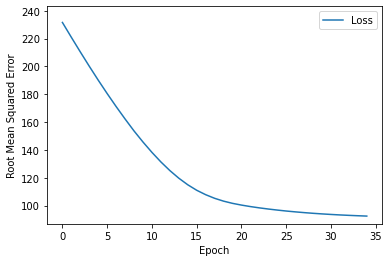


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 5ms/step - loss: 8325.0371 - root_mean_squared_error: 91.2416


[8325.037109375, 91.24163818359375]

In [75]:
#@title Test your model performance using feature cross.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)